# PROBLEM STATEMENT: BANK CUSTOMER CHURN PREDICTION

### The dataset on bank customer churn is widely employed to forecast customer churning or exiting within the banking sector. It encompasses details about customers who have either departed from the bank or are currently active customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import warnings
import os
import sys
import xgboost as xgb


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
train_syn=pd.read_csv(r"C:\Users\kisho\OneDrive\Documents\Project Dataset\train.csv")
test=pd.read_csv(r"C:\Users\kisho\OneDrive\Documents\Project Dataset\test.csv")
train_org=pd.read_csv(r"C:\Users\kisho\OneDrive\Documents\Project Dataset\Churn_Modelling.csv")
sub=pd.read_csv(r"C:\Users\kisho\OneDrive\Documents\Project Dataset\sample_submission.csv")

In [3]:
train_syn.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Data Exploration: 

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides

Gender: The customer's gender

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card

IsActiveMember: Whether the customer is an active member

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (Target Variable)

In [4]:
train_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
train_org.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploritory Data Analysis

Exploratory Data Analysis (EDA) is an analysis approach that identifies general patterns in the data.
These patterns include outliers and features of the data that might be unexpected. 
EDA is an important first step in any data analysis.


Null Values:
    
Missing data / Null values is defined as the values or data that is not stored (or not present) for some variables in the given dataset.
Here is a list of popular strategies to handle missing values in a dataset.

Deleting the Column having Missing Values

Deleting Row having Missing Values

Imputing the Missing Values


In [6]:
train_syn.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Separating Numerical and Categorical Features

In [7]:
FEATURES = train_syn.columns.drop(['id','CustomerId','Exited'])

In [8]:
NUM_FEATURES = train_syn._get_numeric_data().columns.drop(['id','CustomerId','Exited']).tolist()

In [9]:
CAT_FEATURES = FEATURES.drop(NUM_FEATURES).tolist()

In [10]:
num_to_cat = ['Tenure','NumOfProducts','HasCrCard','IsActiveMember']
CAT_FEATURES.extend(num_to_cat)
NUM_FEATURES = [x for x in NUM_FEATURES if x not in num_to_cat]

print("Numerical Features: ",NUM_FEATURES)
print("Categorical Features: ",CAT_FEATURES,end = "\n\n")
print(train_syn.isnull().sum())

Numerical Features:  ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Categorical Features:  ['Surname', 'Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Adding few Numerical Columns which are not wide and varied dataset either having binary dataset or limited values into categorical features

### Describing Data

In [11]:
df_1 = pd.DataFrame(train_syn[NUM_FEATURES].describe().T)
df_1 = df_1.add_suffix('_syn')
df_2 = pd.DataFrame(train_org[NUM_FEATURES].describe().T)
df_2 = df_2.add_suffix('_org')
df = pd.concat([df_1,df_2],axis = 1)
del df_1, df_2
new_cols = ['count_syn','count_org','mean_syn','mean_org','std_syn','std_org','min_syn','min_org',
            '25%_syn','25%_org','50%_syn','50%_org','75%_syn','75%_org','max_syn','max_org']
df = df[new_cols]
df.style.background_gradient(axis = 0,subset = ['mean_syn','mean_org','std_syn','std_org'])

,count_syn,count_org,mean_syn,mean_org,std_syn,std_org,min_syn,min_org,25%_syn,25%_org,50%_syn,50%_org,75%_syn,75%_org,max_syn,max_org
CreditScore,165034.000000,10000.000000,656.454373,650.528800,80.103340,96.653299,350.000000,350.000000,597.000000,584.000000,659.000000,652.000000,710.000000,718.000000,850.000000,850.000000
Age,165034.000000,10000.000000,38.125888,38.921800,8.867205,10.487806,18.000000,18.000000,32.000000,32.000000,37.000000,37.000000,42.000000,44.000000,92.000000,92.000000
Balance,165034.000000,10000.000000,55478.086689,76485.889288,62817.663278,62397.405202,0.000000,0.000000,0.000000,0.000000,0.000000,97198.540000,119939.517500,127644.240000,250898.090000,250898.090000
EstimatedSalary,165034.000000,10000.000000,112574.822734,100090.239881,50292.865585,57510.492818,11.580000,11.580000,74637.570000,51002.110000,117948.000000,100193.915000,155152.467500,149388.247500,199992.480000,199992.480000


### Concating Synthetic and Original dataset

In [12]:
train_syn.drop(['id','CustomerId'],axis = 1,inplace=True)
train_org.drop(['RowNumber','CustomerId'],axis = 1, inplace = True)

train = pd.concat([train_syn,train_org],axis = 0)
print("Shape Before dropping null values : ", train.shape)

## drop null values
train.dropna(inplace=True)
print("Shape After dropping null values:", train.shape, end = "\n\n")
print(train.isnull().sum(), end = "\n\n")
train.reset_index(drop=True,inplace=True)
train.head()

Shape Before dropping null values :  (175034, 12)
Shape After dropping null values: (175034, 12)

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64



,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Data Visualization

### Target

0    138076
1     36958
Name: Exited, dtype: int64



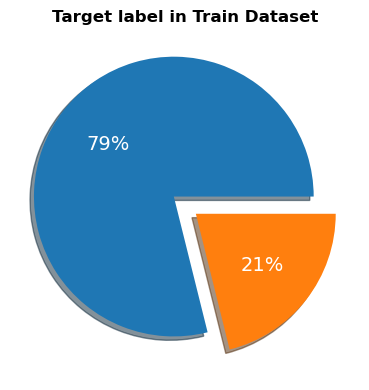

In [75]:
target_counts = train['Exited'].value_counts()
print(target_counts, end = '\n\n')

fig, axs = plt.subplots(1,1,figsize=(6,4))

axs.pie(
    train['Exited'].value_counts(), 
    shadow=True, 
    explode=[.1 for i in range(train['Exited'].nunique())],  # Adjust the explode based on the number of unique values
    autopct='%1.f%%',
    textprops={'size': 14, 'color': 'white'}
)
axs.set_title('Target label in Train Dataset', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

#### Some Observations from above plots:

We can see that data is highly imbalanced. Almost 80% of our data is from class 0 (not exited) and 20% data is from class 1 (exited).

### Categorical Features

In [14]:
print(CAT_FEATURES)

['Surname', 'Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [15]:
def plot_cat(feature):
    f = feature
    fig ,axs = plt.subplots(1,2,figsize = (10,4))
    fig.suptitle('Feature ='+f)

    sns.countplot(ax = axs[0],data = train, x = f)
    axs[0].set_title("Countplot")

    sns.countplot(ax = axs[1],data = train, x = f,hue="Exited")
    axs[1].set_title("Countplot with Exited")
    plt.show()

In [16]:
top_surnames = pd.DataFrame(train['Surname'].value_counts()[:15])
top_surnames = top_surnames.reset_index()
top_surnames

,index,Surname
0,Hsia,2474
1,T'ien,2300
2,Hs?,1626
3,Maclean,1601
4,Kao,1597
5,Ts'ui,1586
6,P'eng,1520
7,H?,1439
8,Hsueh,1320
9,Shih,1276


<Axes: title={'center': 'Top Surname who exited (Countwise) in Train Data'}, xlabel='Surname', ylabel='count'>

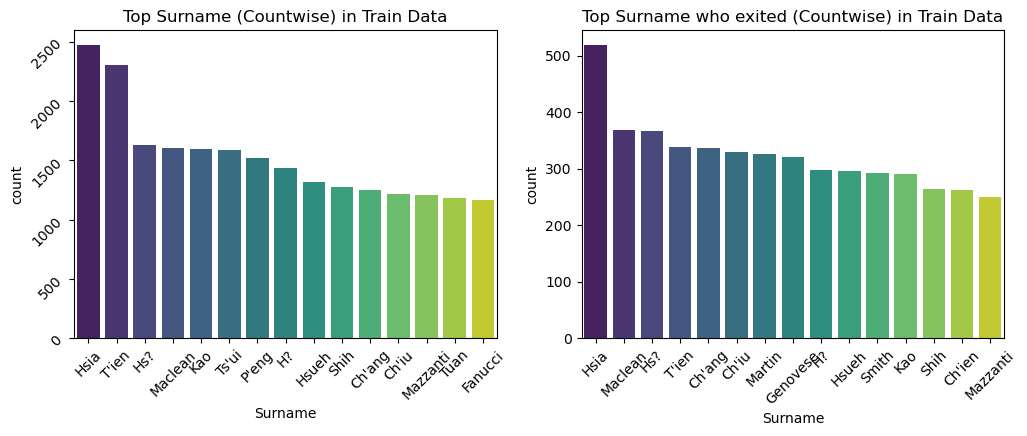

In [17]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
top_surnames = pd.DataFrame(train['Surname'].value_counts()[:15])
top_surnames = top_surnames.reset_index()
top_surnames = top_surnames.rename(columns={'Surname':'count','index':'Surname'})
top_surnames['count'] = top_surnames['count'].astype(int)
sns.barplot(ax=axs[0],x="Surname",y="count",data = top_surnames,palette="viridis")
axs[0].tick_params(labelrotation=45)

axs[0].set_title("Top Surname (Countwise) in Train Data")
top_surnames_exited = pd.DataFrame(train[train["Exited"] == 1]['Surname'].value_counts()[:15])
top_surnames_exited = top_surnames_exited.reset_index()
top_surnames_exited = top_surnames_exited.rename(columns={'Surname':'count','index':'Surname'})
top_surnames_exited['count'] = top_surnames_exited['count'].astype(int)
plt.xticks(rotation=45)
axs[1].set_title("Top Surname who exited (Countwise) in Train Data")
sns.barplot(ax = axs[1],x='Surname', y='count', data = top_surnames_exited, palette='viridis')

Percentage of cutomers from France Exited : 16.51 %
Percentage of customers from Spain Exited : 17.18 %
Percentage of customers Exited from Germany: 37.53 %



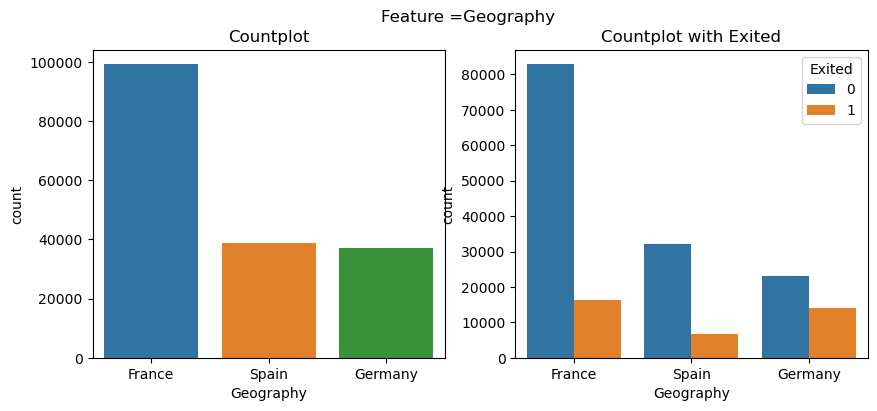

In [18]:
count = train[train['Geography'] == 'France']["Exited"].value_counts()
print("Percentage of cutomers from France Exited : {:.2f}".format((count[1]/count.sum())*100),"%")

count = train[train['Geography'] == 'Spain']["Exited"].value_counts()
print("Percentage of customers from Spain Exited : {:.2f}".format((count[1]/count.sum())*100),"%")

count = train[train['Geography'] == 'Germany']["Exited"].value_counts()
print("Percentage of customers Exited from Germany: {:.2f}".format((count[1]/count.sum())*100),"%")
print()
plot_cat(CAT_FEATURES[1])

Total percentage of Male Exited : 15.94 %
Total percentage of Female Exited : 27.80 %



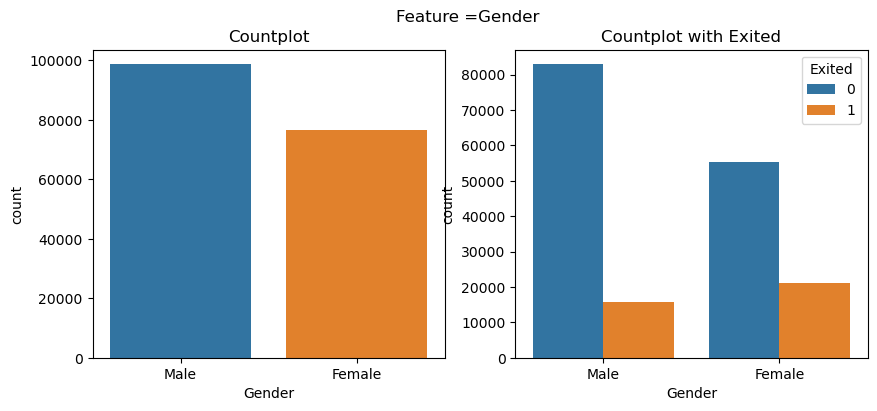

In [19]:
count = train[train['Gender'] == 'Male']["Exited"].value_counts()
print("Total percentage of Male Exited : {:.2f}".format((count[1]/count.sum())*100),"%")
count = train[train['Gender'] == 'Female']["Exited"].value_counts()
print("Total percentage of Female Exited : {:.2f}".format((count[1]/count.sum())*100),"%")
print()

plot_cat(CAT_FEATURES[2])

Total percentage of Customer with Tenure 0 Exited 25.30 %
Total percentage of Customer with Tenure 1 Exited 22.60 %
Total percentage of Customer with Tenure 2 Exited 19.47 %
Total percentage of Customer with Tenure 3 Exited 22.81 %
Total percentage of Customer with Tenure 4 Exited 22.53 %
Total percentage of Customer with Tenure 5 Exited 21.93 %
Total percentage of Customer with Tenure 6 Exited 19.90 %
Total percentage of Customer with Tenure 7 Exited 18.68 %
Total percentage of Customer with Tenure 8 Exited 19.76 %
Total percentage of Customer with Tenure 9 Exited 21.23 %
Total percentage of Customer with Tenure 10 Exited 21.22 %



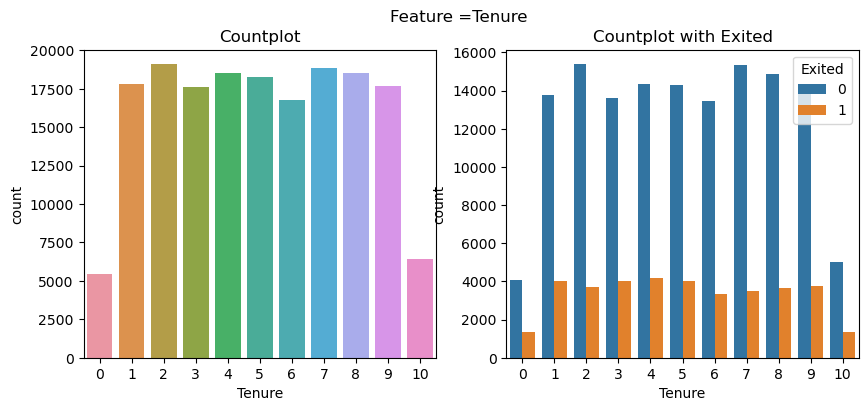

In [20]:
for i in range(11):
    count = train[train['Tenure'] == i]["Exited"].value_counts()
    print("Total percentage of Customer with Tenure " +str(i) +" Exited {:.2f}".format((count[1]/count.sum())*100),"%")
print()

plot_cat(CAT_FEATURES[3])

Total percentage of Customer with num of products 1 Exited 34.28 %
Total percentage of Customer with num of products 2 Exited 6.12 %
Total percentage of Customer with num of products 3 Exited 87.78 %
Total percentage of Customer with num of products 4 Exited 88.97 %



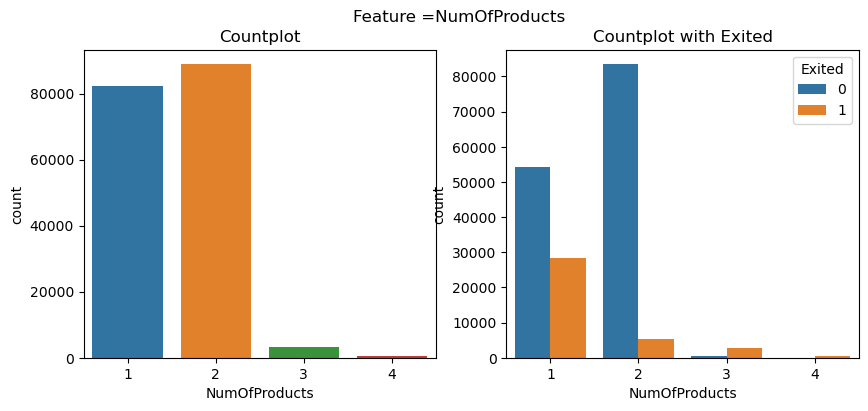

In [21]:
for i in range(1,5):
    count = train[train['NumOfProducts'] == i]["Exited"].value_counts()
    print("Total percentage of Customer with num of products " +str(i) +" Exited {:.2f}".format((count[1]/count.sum())*100),"%")
print()

plot_cat(CAT_FEATURES[4])

Total percentage of Customer with Credit Card Exited 20.62 %



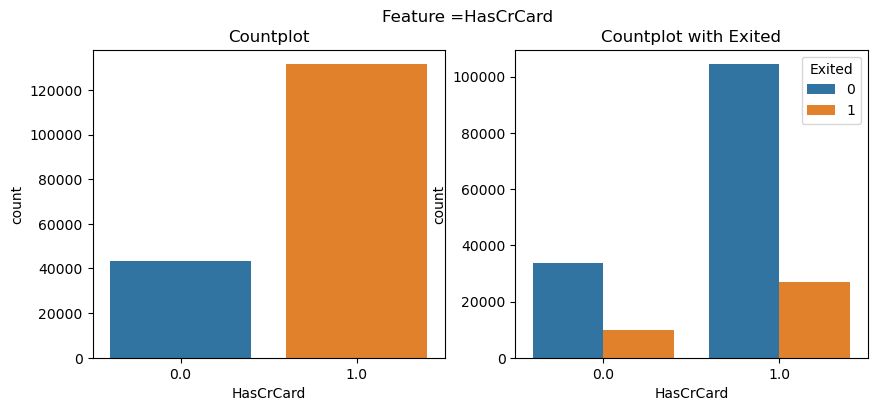

In [22]:
count = train[train['HasCrCard'] == 1]["Exited"].value_counts()
print("Total percentage of Customer with Credit Card Exited {:.2f}".format((count[1]/count.sum())*100),"%")
print()

plot_cat(CAT_FEATURES[5])

Churn rate in customers who are Not Active Members 29.55 %
Churn rate in customers who are Active Members 12.64 %



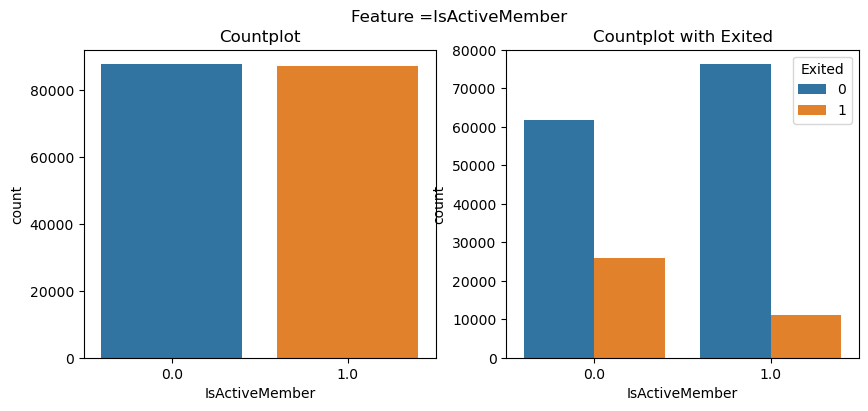

In [23]:
count = train[train['IsActiveMember'] == 0]["Exited"].value_counts()
print("Churn rate in customers who are Not Active Members {:.2f}".format((count[1]/count.sum())*100),"%")

count = train[train['IsActiveMember'] == 1]["Exited"].value_counts()
print("Churn rate in customers who are Active Members {:.2f}".format((count[1]/count.sum())*100),"%")
print()

plot_cat(CAT_FEATURES[6])

### Numerical Features

In [24]:
def plot_num(f):
    
    print(train[f].describe())
    print()
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,4))
    plt.suptitle(f)
    sns.histplot(ax = axs[0,0], data = train, x = f,bins=50)
    sns.histplot(ax = axs[0,1], data = train, x = f,hue="Exited",bins=50)

    sns.boxplot(ax = axs[1,0], data=train, y=f)
    sns.boxplot(ax = axs[1,1], data=train, x="Exited", y=f)
    plt.show()

print(NUM_FEATURES)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


count    175034.000000
mean        656.115835
std          81.151171
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
Name: CreditScore, dtype: float64



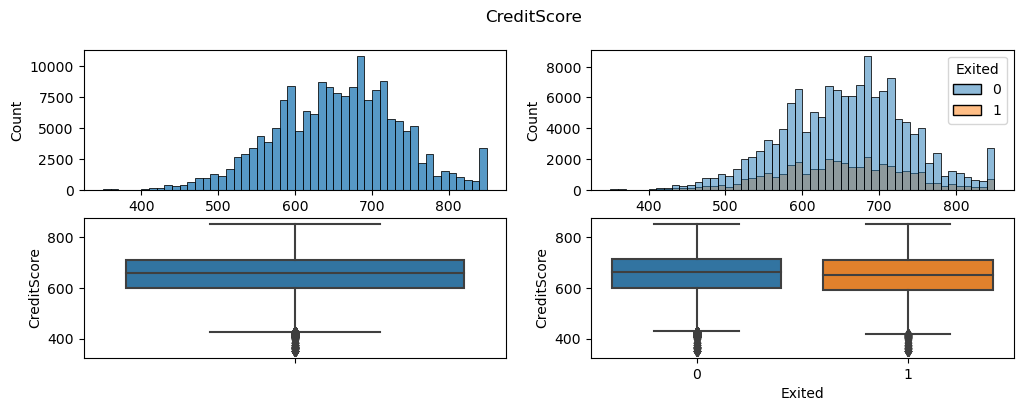

In [25]:
plot_num(NUM_FEATURES[0])

count    175034.000000
mean         38.171360
std           8.969552
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64



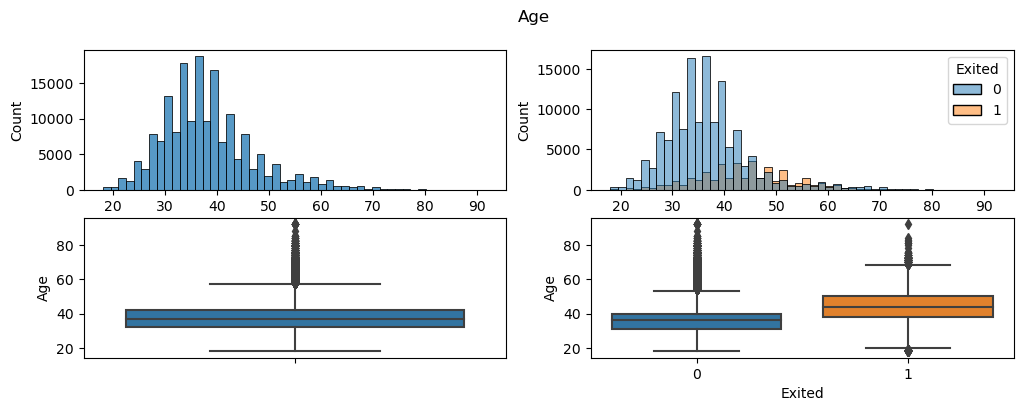

In [26]:
plot_num(NUM_FEATURES[1])

In [82]:
train['Balance'].value_counts()

0.00         93265
124577.33       89
127864.40       65
122314.50       64
129855.32       60
             ...  
133467.63        1
104450.05        1
101191.80        1
99845.24         1
90022.85         1
Name: Balance, Length: 30239, dtype: int64

Balance column is having too much values = 0, more than 50% of data is having balance 0 so to vizualise properly we are putting data other than value = 0

count     81769.000000
mean     121325.067588
std       25455.660635
min          18.330000
25%      104796.540000
50%      122104.790000
75%      137841.530000
max      250898.090000
Name: Balance, dtype: float64



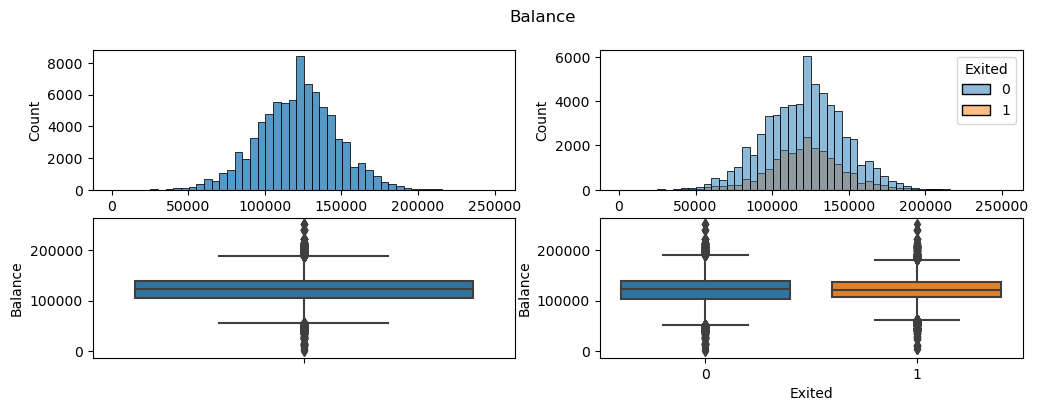

In [27]:
f = NUM_FEATURES[2]
df_ = train[train['Balance'] != 0]
print(df_[f].describe())
print()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,4))
plt.suptitle(f)
sns.histplot(ax = axs[0,0], data = df_, x = f,bins=50)
sns.histplot(ax = axs[0,1], data = df_, x = f,hue="Exited",bins=50)

sns.boxplot(ax = axs[1,0], data=df_, y=f)
sns.boxplot(ax = axs[1,1], data=df_, x="Exited", y=f)
plt.show()

count    175034.000000
mean     111861.556577
std       50815.382991
min          11.580000
25%       73192.370000
50%      116969.730000
75%      154767.340000
max      199992.480000
Name: EstimatedSalary, dtype: float64



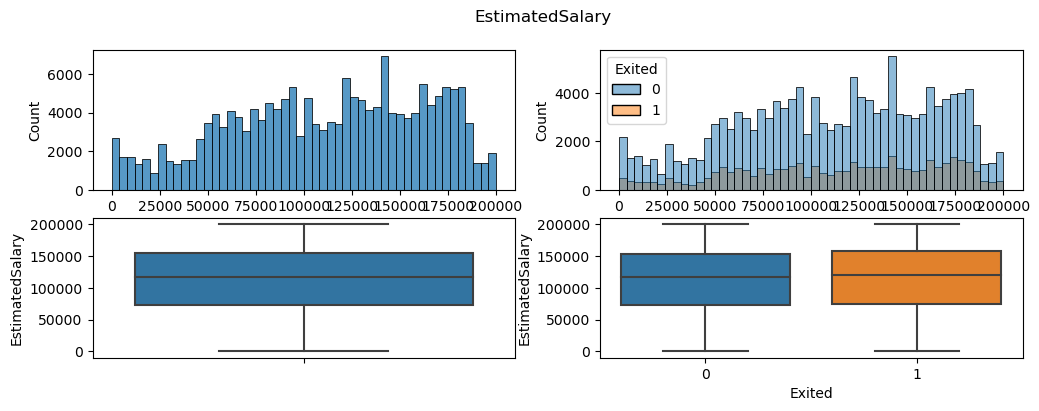

In [28]:
plot_num(NUM_FEATURES[3])

## Feature Processing and Engineering`

In this part we will do:

Encode categorical features
Add new features
Preprocess Num Featues

In [29]:
train_mod = train.copy()
test_mod = test.copy()
train[CAT_FEATURES].head()

,Surname,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember
0,Okwudilichukwu,France,Male,3,2,1.0,0.0
1,Okwudiliolisa,France,Male,1,2,1.0,1.0
2,Hsueh,France,Male,10,2,1.0,0.0
3,Kao,France,Male,2,1,1.0,1.0
4,Chiemenam,Spain,Male,5,2,1.0,1.0


### TF-IDF Encoding for Surnames

A very strange observation came out while running the model, if we are not including surname column as it is categorical and not having any importance in model, the auc score is reduced drastically. So here we are vectorizing this categorical colunmn in order to include in our model.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [31]:
def tf_idf(df_train,df_test,column,n,p):
    vectorizer = TfidfVectorizer(max_features=n)
    vectors_train = vectorizer.fit_transform(df_train[column])
    vectors_test =vectorizer.transform(df_test[column])
    
    svd = TruncatedSVD(p)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)
    
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)
    cols=[(column+"_tfidf_"+str(f)) for f in tfidf_df_train.columns]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols
    
    df_train = pd.concat([df_train, tfidf_df_train],axis = "columns")
    df_test = pd.concat([df_test,tfidf_df_test], axis = "columns")
    
    return df_train, df_test

train_mod, test_mod = tf_idf(train_mod,test_mod,'Surname',1000,5)

### Binning / Grouping CreditScore and Age Columns for encoding

In [32]:
train_mod['CreditScoreGroup'] = pd.cut(train_mod['CreditScore'],bins = [300,579,669,739,799,850],
                      labels=['Excellent','VeryGood','Good','Fair','Poor'])

test_mod['CreditScoreGroup'] = pd.cut(test['CreditScore'],bins = [300,579,669,739,799,850],
                      labels=['Excellent','VeryGood','Good','Fair','Poor'])

### AGE

In [33]:
train_mod['AgeGroups'] = pd.cut(train_mod['Age'], bins = [17,30,40,50,60,70,95],
                           labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+'],
                           right=False)

test_mod['AgeGroups'] = pd.cut(test_mod['Age'], bins = [17,30,40,50,60,70,95],
                           labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+'],
                           right=False)

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
one_hot_features = ['CreditScoreGroup','Geography','Gender','AgeGroups']
one_hot = OneHotEncoder()
new_cols = one_hot.fit_transform(train_mod[one_hot_features]).toarray().astype('int8')
col_names = one_hot.get_feature_names_out()
train_mod[col_names] = new_cols
train_mod.drop(one_hot_features,axis = 1,inplace=True)

one_hot = OneHotEncoder()
new_cols = one_hot.fit_transform(test_mod[one_hot_features]).toarray().astype('int8')
col_names = one_hot.get_feature_names_out()
test_mod[col_names] = new_cols
test_mod.drop(one_hot_features,axis = 1,inplace=True)

In [36]:
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
train_mod[NUM_FEATURES] = scaler.fit_transform(train[NUM_FEATURES])
test_mod[NUM_FEATURES] = scaler.transform(test[NUM_FEATURES])

train_mod.head()

,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,...,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,AgeGroups_18-29,AgeGroups_30-39,AgeGroups_40-49,AgeGroups_50-59,AgeGroups_60-69,AgeGroups_70+
0,Okwudilichukwu,0.146445,-0.576548,3,-0.899907,2,1.0,0.0,1.369440,0,...,0,0,0,1,0,1,0,0,0,0
1,Okwudiliolisa,-0.358786,-0.576548,1,-0.899907,2,1.0,1.0,-1.227153,0,...,0,0,0,1,0,1,0,0,0,0
2,Hsueh,0.269672,0.203873,10,-0.899907,2,1.0,0.0,1.436678,0,...,0,0,0,1,0,0,1,0,0,0
3,Kao,-0.925631,-0.465059,2,1.463969,1,1.0,1.0,-0.537254,0,...,0,0,0,1,0,1,0,0,0,0
4,Chiemenam,0.737936,-0.576548,5,-0.899907,2,1.0,1.0,-1.904797,0,...,0,1,0,1,0,1,0,0,0,0


### Model

In [38]:
train_mod.columns

Index(['Surname', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Surname_tfidf_3', 'Surname_tfidf_4', 'CreditScoreGroup_Excellent',
       'CreditScoreGroup_Fair', 'CreditScoreGroup_Good',
       'CreditScoreGroup_Poor', 'CreditScoreGroup_VeryGood',
       'Geography_France', 'Geography_Germany', 'Geography_Spain',
       'Gender_Female', 'Gender_Male', 'AgeGroups_18-29', 'AgeGroups_30-39',
       'AgeGroups_40-49', 'AgeGroups_50-59', 'AgeGroups_60-69',
       'AgeGroups_70+'],
      dtype='object')

In [74]:
FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Surname_tfidf_3', 'Surname_tfidf_4','Geography_France', 'Geography_Germany',
       'Geography_Spain','Gender_Female', 'Gender_Male', 'AgeGroups_18-29',
       'AgeGroups_30-39','AgeGroups_40-49', 'AgeGroups_50-59', 'AgeGroups_60-69',
       'AgeGroups_70+']
FEATURES = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'Surname_tfidf_0', 'Surname_tfidf_2','Surname_tfidf_3', 'Surname_tfidf_4',
            'IsActiveMember', 'EstimatedSalary', 'Geography_France', 'Geography_Germany',
            'Gender_Female', 'AgeGroups_18-29', 'AgeGroups_30-39', 'AgeGroups_40-49', 'AgeGroups_50-59',
            'AgeGroups_60-69', 'AgeGroups_70+']
train_mod[FEATURES].head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,Surname_tfidf_0,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,...,EstimatedSalary,Geography_France,Geography_Germany,Gender_Female,AgeGroups_18-29,AgeGroups_30-39,AgeGroups_40-49,AgeGroups_50-59,AgeGroups_60-69,AgeGroups_70+
0,0.146445,-0.576548,3,-0.899907,2,1.0,1.049312e-07,-2.411914e-07,-0.000006,-8.768487e-07,...,1.369440,1,0,0,0,1,0,0,0,0
1,-0.358786,-0.576548,1,-0.899907,2,1.0,2.647820e-07,-1.105977e-06,-0.000021,7.071156e-06,...,-1.227153,1,0,0,0,1,0,0,0,0
2,0.269672,0.203873,10,-0.899907,2,1.0,-4.126977e-04,5.313976e-05,-0.028845,-8.773664e-03,...,1.436678,1,0,0,0,0,1,0,0,0
3,-0.925631,-0.465059,2,1.463969,1,1.0,7.087567e-04,-1.452825e-03,0.013256,1.802350e-02,...,-0.537254,1,0,0,0,1,0,0,0,0
4,0.737936,-0.576548,5,-0.899907,2,1.0,2.401101e-07,1.130171e-06,-0.000003,-1.548259e-06,...,-1.904797,0,0,0,0,1,0,0,0,0


In [40]:
warnings.simplefilter('ignore')

In [55]:
X, y = train_mod[FEATURES], train_mod["Exited"]
X_test = test_mod[FEATURES]

Running all models on train_test_split

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Logistic Regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_preds_train = logistic_model.predict_proba(X_train)[:, 1]
logistic_preds_test = logistic_model.predict_proba(X_test)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds_train = rf_model.predict_proba(X_train)[:, 1]
rf_preds_test = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds_train = xgb_model.predict_proba(X_train)[:, 1]
xgb_preds_test = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate models
def evaluate_model(predictions_train, predictions_test, y_true):
    train_auc = roc_auc_score(y_true, predictions_train)
    test_auc = roc_auc_score(y_true, predictions_test)
    
    train_accuracy = accuracy_score(y_true, (predictions_train > 0.5).astype(int))
    test_accuracy = accuracy_score(y_true, (predictions_test > 0.5).astype(int))
    
    return train_auc, test_auc, train_accuracy, test_accuracy

# Evaluate Logistic Regression
logistic_train_auc, logistic_test_auc, logistic_train_accuracy, logistic_test_accuracy = evaluate_model(logistic_preds_train, logistic_preds_test, y_train)

# Evaluate Random Forest
rf_train_auc, rf_test_auc, rf_train_accuracy, rf_test_accuracy = evaluate_model(rf_preds_train, rf_preds_test, y_train)

# Evaluate XGBoost
xgb_train_auc, xgb_test_auc, xgb_train_accuracy, xgb_test_accuracy = evaluate_model(xgb_preds_train, xgb_preds_test, y_train)

# Display results
print("Logistic Regression:")
print(f"Train AUC: {logistic_train_auc:.4f}, Test AUC: {logistic_test_auc:.4f}")
print(f"Train Accuracy: {logistic_train_accuracy:.4f}, Test Accuracy: {logistic_test_accuracy:.4f}")

print("\nRandom Forest:")
print(f"Train AUC: {rf_train_auc:.4f}, Test AUC: {rf_test_auc:.4f}")
print(f"Train Accuracy: {rf_train_accuracy:.4f}, Test Accuracy: {rf_test_accuracy:.4f}")

print("\nXGBoost:")
print(f"Train AUC: {xgb_train_auc:.4f}, Test AUC: {xgb_test_auc:.4f}")
print(f"Train Accuracy: {xgb_train_accuracy:.4f}, Test Accuracy: {xgb_test_accuracy:.4f}")


Logistic Regression:
Train AUC: 0.8243, Test AUC: 0.5007
Train Accuracy: 0.8396, Test Accuracy: 0.7177

Random Forest:
Train AUC: 1.0000, Test AUC: 0.4980
Train Accuracy: 0.9979, Test Accuracy: 0.6994

XGBoost:
Train AUC: 0.9213, Test AUC: 0.4981
Train Accuracy: 0.8851, Test Accuracy: 0.6965


Data is highly imbalanced even stratify = y is not able to help much

using StratifiedKFold to remove this imbalance and get better validation score

In [57]:
X, y = train_mod[FEATURES], train_mod["Exited"]
X_test = test_mod[FEATURES]

#### Logistic Model

In [58]:
scores=[]
logistic_model = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(estimator=logistic_model,X = X,y = y, cv=cv, scoring='roc_auc')
print(np.mean(cross_val_results))

logistic_model.fit(X,y)
pred_logistic = logistic_model.predict_proba(X_test)

0.8251194357686309


#### Random Forest Model

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
random_forest_model = RandomForestClassifier(n_estimators = 40,random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_results = cross_val_score(estimator=random_forest_model,X = X,y = y, cv=cv, scoring='roc_auc',verbose=True)
                                     
print(np.mean(cross_val_results))

random_forest_model.fit(X,y)
pred_random_forest = random_forest_model.predict_proba(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


0.8629792519498751


#### XGBClassifier

In [61]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna

Hyperparamter Tuning and Validation

In [62]:
def objective(trial, X, y, features, n_splits=5):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1,log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50,200),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42}
    
    model = xgb.XGBClassifier(**params)
    
    train_scores = []
    val_scores = []
    
    skf = StratifiedKFold(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train[features], y_train, 
                  eval_set=[(X_val[features], y_val)], 
                  verbose=500,
                  early_stopping_rounds=50)  # Add early stopping for efficiency

        train_preds = model.predict_proba(X_train[features])[:,1]
        val_preds = model.predict_proba(X_val[features])[:,1]

        train_score = roc_auc_score(y_train, train_preds)
        val_score = roc_auc_score(y_val, val_preds)

        print(f"[Fold {fold+1}] Train score: {train_score:.4f} | Val score: {val_score:.4f}")

        train_scores.append(train_score)
        val_scores.append(val_score)
        
    avg_val_score = np.mean(val_scores)
    avg_train_score = np.mean(train_scores)
    print(f"avg train score {avg_train_score:4f}, avg val score {avg_val_score:.4f}")
    return avg_val_score

def optimize_xgb_model(X, y, features, n_trials=5):
    study = optuna.create_study(direction='maximize')
    objective_func = lambda trial: objective(trial, X, y, features)
    study.optimize(objective_func, n_trials=n_trials)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    return best_params


best_params = optimize_xgb_model(X, y, FEATURES)


[I 2024-01-22 03:00:23,942] A new study created in memory with name: no-name-df143686-09bf-4c5f-9258-d49313f7e983


[0]	validation_0-logloss:0.51296
[111]	validation_0-logloss:0.34465
[Fold 1] Train score: 0.9055 | Val score: 0.8910
[0]	validation_0-logloss:0.51304
[111]	validation_0-logloss:0.34799
[Fold 2] Train score: 0.9064 | Val score: 0.8858
[0]	validation_0-logloss:0.51296
[111]	validation_0-logloss:0.34591
[Fold 3] Train score: 0.9063 | Val score: 0.8872
[0]	validation_0-logloss:0.51302
[111]	validation_0-logloss:0.34693
[Fold 4] Train score: 0.9054 | Val score: 0.8888
[0]	validation_0-logloss:0.51308
[111]	validation_0-logloss:0.35283


[I 2024-01-22 03:00:47,533] Trial 0 finished with value: 0.8866184394251488 and parameters: {'max_depth': 10, 'learning_rate': 0.012816749656309127, 'n_estimators': 112, 'subsample': 0.7973969291681433, 'colsample_bytree': 0.7730693288062356, 'reg_alpha': 0.7963648404945882, 'reg_lambda': 0.8355844872691258}. Best is trial 0 with value: 0.8866184394251488.


[Fold 5] Train score: 0.9076 | Val score: 0.8804
avg train score 0.906239, avg val score 0.8866
[0]	validation_0-logloss:0.51463
[91]	validation_0-logloss:0.36775
[Fold 1] Train score: 0.8923 | Val score: 0.8827
[0]	validation_0-logloss:0.51471
[91]	validation_0-logloss:0.37003
[Fold 2] Train score: 0.8935 | Val score: 0.8775
[0]	validation_0-logloss:0.51462
[91]	validation_0-logloss:0.36857
[Fold 3] Train score: 0.8930 | Val score: 0.8783
[0]	validation_0-logloss:0.51466
[91]	validation_0-logloss:0.36963
[Fold 4] Train score: 0.8926 | Val score: 0.8796
[0]	validation_0-logloss:0.51464
[91]	validation_0-logloss:0.37401


[I 2024-01-22 03:01:04,824] Trial 1 finished with value: 0.8780510926101972 and parameters: {'max_depth': 10, 'learning_rate': 0.01583785387238498, 'n_estimators': 92, 'subsample': 0.2541652657167841, 'colsample_bytree': 0.48680153209169863, 'reg_alpha': 0.23198767458882774, 'reg_lambda': 0.26143930750066247}. Best is trial 0 with value: 0.8866184394251488.


[Fold 5] Train score: 0.8943 | Val score: 0.8722
avg train score 0.893125, avg val score 0.8781
[0]	validation_0-logloss:0.48392
[118]	validation_0-logloss:0.31741
[Fold 1] Train score: 0.9073 | Val score: 0.8921
[0]	validation_0-logloss:0.48430
[118]	validation_0-logloss:0.32238
[Fold 2] Train score: 0.9089 | Val score: 0.8872
[0]	validation_0-logloss:0.48380
[126]	validation_0-logloss:0.31945
[Fold 3] Train score: 0.9095 | Val score: 0.8887
[0]	validation_0-logloss:0.48426
[120]	validation_0-logloss:0.32013
[Fold 4] Train score: 0.9080 | Val score: 0.8899
[0]	validation_0-logloss:0.48444
[125]	validation_0-logloss:0.32827


[I 2024-01-22 03:01:22,267] Trial 2 finished with value: 0.8879409744854501 and parameters: {'max_depth': 8, 'learning_rate': 0.09712326009242553, 'n_estimators': 197, 'subsample': 0.7754057556249525, 'colsample_bytree': 0.6664204488783663, 'reg_alpha': 0.6406376056080703, 'reg_lambda': 0.45997365950972957}. Best is trial 2 with value: 0.8879409744854501.


[Fold 5] Train score: 0.9112 | Val score: 0.8818
avg train score 0.908978, avg val score 0.8879
[0]	validation_0-logloss:0.48677
[91]	validation_0-logloss:0.31894
[Fold 1] Train score: 0.9273 | Val score: 0.8907
[0]	validation_0-logloss:0.48712
[91]	validation_0-logloss:0.32442
[Fold 2] Train score: 0.9240 | Val score: 0.8861
[0]	validation_0-logloss:0.48668
[91]	validation_0-logloss:0.32165
[Fold 3] Train score: 0.9246 | Val score: 0.8873
[0]	validation_0-logloss:0.48714
[91]	validation_0-logloss:0.32272
[Fold 4] Train score: 0.9255 | Val score: 0.8883
[0]	validation_0-logloss:0.48732
[91]	validation_0-logloss:0.33158


[I 2024-01-22 03:01:38,495] Trial 3 finished with value: 0.8863615735184066 and parameters: {'max_depth': 10, 'learning_rate': 0.08854109125520383, 'n_estimators': 92, 'subsample': 0.7253673990340261, 'colsample_bytree': 0.6822420344970399, 'reg_alpha': 0.15950093659049758, 'reg_lambda': 0.5926918477529771}. Best is trial 2 with value: 0.8879409744854501.


[Fold 5] Train score: 0.9261 | Val score: 0.8794
avg train score 0.925508, avg val score 0.8864
[0]	validation_0-logloss:0.49961
[111]	validation_0-logloss:0.31651
[Fold 1] Train score: 0.8934 | Val score: 0.8922
[0]	validation_0-logloss:0.49983
[111]	validation_0-logloss:0.32147
[Fold 2] Train score: 0.8944 | Val score: 0.8875
[0]	validation_0-logloss:0.49904
[111]	validation_0-logloss:0.31853
[Fold 3] Train score: 0.8940 | Val score: 0.8894
[0]	validation_0-logloss:0.49982
[111]	validation_0-logloss:0.31964
[Fold 4] Train score: 0.8938 | Val score: 0.8901
[0]	validation_0-logloss:0.49972
[111]	validation_0-logloss:0.32709


[I 2024-01-22 03:01:52,457] Trial 4 finished with value: 0.8882582072653896 and parameters: {'max_depth': 6, 'learning_rate': 0.05259758051279791, 'n_estimators': 112, 'subsample': 0.828249726450023, 'colsample_bytree': 0.880671903282529, 'reg_alpha': 0.8182458651407676, 'reg_lambda': 0.7631476552189783}. Best is trial 4 with value: 0.8882582072653896.


[Fold 5] Train score: 0.8955 | Val score: 0.8821
avg train score 0.894231, avg val score 0.8883
Best Hyperparameters: {'max_depth': 6, 'learning_rate': 0.05259758051279791, 'n_estimators': 112, 'subsample': 0.828249726450023, 'colsample_bytree': 0.880671903282529, 'reg_alpha': 0.8182458651407676, 'reg_lambda': 0.7631476552189783}


In [63]:
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X, y)
pred_xgb = best_model.predict_proba(X_test)

### Model Performance and Feature Importance

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

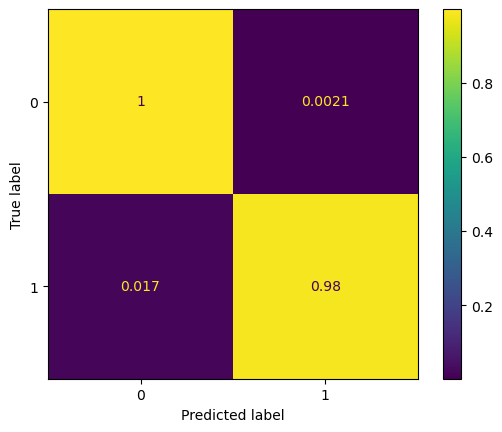

In [73]:
y_hat = np.argmax(random_forest_model.predict_proba(X),axis = 1)
ConfusionMatrixDisplay.from_predictions(train_mod["Exited"], 
                                        y_hat,
                                        normalize='true',
                                        display_labels=['0','1'])

plt.show()

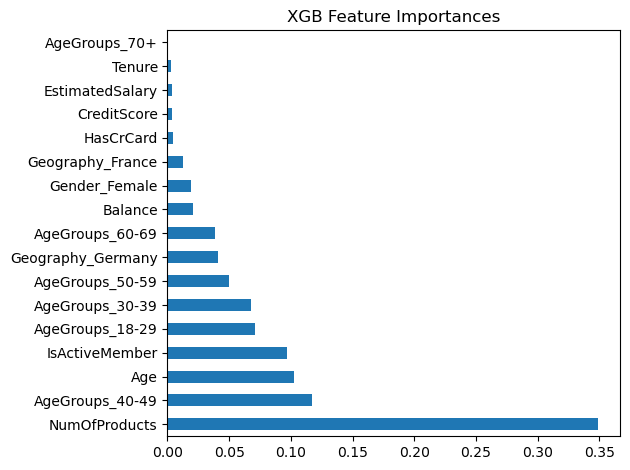

XGB Classifier importances:['NumOfProducts', 'AgeGroups_40-49', 'Age', 'IsActiveMember', 'AgeGroups_18-29', 'AgeGroups_30-39', 'AgeGroups_50-59', 'Geography_Germany', 'AgeGroups_60-69', 'Balance', 'Gender_Female', 'Geography_France', 'HasCrCard', 'CreditScore', 'EstimatedSalary', 'Tenure', 'AgeGroups_70+']


In [66]:
xgb_feat_importances = pd.Series(best_model.feature_importances_, index=FEATURES)
xgb_feat_importances.sort_values(ascending =False,inplace=True)

xgb_feat_importances.plot(kind='barh',title='XGB Feature Importances')

plt.tight_layout()
plt.show()

print(f"XGB Classifier importances:{xgb_feat_importances.nlargest(99).index.tolist()}")

### Submission

In [67]:
sub = pd.DataFrame(test['id'])
sub['Exited'] = pred_xgb[:,1]
threshold = 0.5
sub['Binary_Exited'] = (sub['Exited'] > threshold).astype(int)

sub.to_csv('submission.csv',index = False)
sub

,id,Exited,Binary_Exited
0,165034,0.021019,0
1,165035,0.827176,1
2,165036,0.028506,0
3,165037,0.226864,0
4,165038,0.345262,0
...,...,...,...
110018,275052,0.048757,0
110019,275053,0.107913,0
110020,275054,0.021987,0
110021,275055,0.145727,0
